# Wrangling III 

In this tutorial, we'll round out our focus on data wrangling by looking 

- handling duplicate values
- data transformations

## Preliminaries

As usual, we'll load some libraries we'll be likely to use.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now we'll get set up to work by

- loading the cancer data and cleaning it up (as before)
- trim out some columns so we can look at the data frame more easily
- shorten up some of the column names to save ourselves some typing

Let's reuse our function to do the loading and cleaning.

In [3]:
def bcd_load_clean():
    bcd = pd.read_csv('./data/breast_cancer_data.csv')
    bcd['patient_id'] = bcd['patient_id'].astype('string')
    bcd['doctor_name'] = bcd['doctor_name'].str.split().str[1]
    bcd['bare_nuclei'] = bcd['bare_nuclei'].replace('?', '')
    bcd['bare_nuclei'] = pd.to_numeric(bcd['bare_nuclei'])
    
    return bcd

In [4]:
bcd = bcd_load_clean()

Make a little version with just two numeric columns to play with.

In [5]:
bcd2 = bcd[['patient_id', 'clump_thickness', 'bland_chromatin', 'class']].copy()

Let's give the columns shorter names to save some typing.

In [6]:
bcd2 = bcd2.rename(columns={'clump_thickness': 'thick',
                            'bland_chromatin': 'chrom',
                            'patient_id': 'id'})

## Duplicate entries

As we have already seen, datasets can contain strange things that we have to overcome prior to analysis. One of the most common issues in a dataset are duplicate entries. These are common with large datasets that have been transcribed by humans at some point. Humands get bored, lose their place, etc.

---

Let's look at the shape of our cancer data frame (remember data frames have a `shape` attribute).

In [8]:
bcd2.shape

(699, 4)

---

Now let's look at the number of unique entries using the `nunique()` data frame method; this will return the number of distinct values in each column.

In [9]:
bcd2.nunique()

id       645
thick     10
chrom     10
class      2
dtype: int64

---

So we can see that, while there are 699 observations in our data, there are only 645 unique patient ids. This tells us that several patients have multiple entries. These could be from patients making multiple visits to the doctor, or they could be a mistakes, or some combination thereof.

We can find out which rows – which entire observations – are identical with the `duplicated()` method. 

In [10]:
bcd2.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
694    False
695    False
696    False
697    False
698     True
Length: 699, dtype: bool

That's not terribly helpful by itself, but...

---

In the cell below, count the number of duplicated rows (remember a True is a 1).

In [11]:
bcd2.duplicated().sum()

12

---

We can also use the output of `.duplicated()` to do logical indexing to see the observations that have duplicates. Do that in the cell below.

In [12]:
bcd2[bcd2.duplicated()]

,id,thick,chrom,class
208,1218860,1.0,3.0,benign
253,1100524,6.0,7.0,malignant
254,1116116,9.0,3.0,malignant
258,1198641,3.0,3.0,benign
272,320675,3.0,7.0,malignant
322,733639,3.0,3.0,benign
338,704097,1.0,2.0,benign
443,734111,1.0,1.0,benign
561,1321942,5.0,3.0,benign
684,466906,1.0,1.0,benign


---

This is promising but, if we look at what is listed, we don't actually see any duplicates. So what is `duplicates()` doing?

---

Use the cell below to get help on `duplicated()` using `help()` or `?`.

In [13]:
help(bcd2.duplicated)

Help on method duplicated in module pandas.core.frame:

duplicated(subset: 'Hashable | Sequence[Hashable] | None' = None, keep: 'DropKeep' = 'first') -> 'Series' method of pandas.core.frame.DataFrame instance
    Return boolean Series denoting duplicate rows.
    
    Considering certain columns is optional.
    
    Parameters
    ----------
    subset : column label or sequence of labels, optional
        Only consider certain columns for identifying duplicates, by
        default use all of the columns.
    keep : {'first', 'last', False}, default 'first'
        Determines which duplicates (if any) to mark.
    
        - ``first`` : Mark duplicates as ``True`` except for the first occurrence.
        - ``last`` : Mark duplicates as ``True`` except for the last occurrence.
        - False : Mark all duplicates as ``True``.
    
    Returns
    -------
    Series
        Boolean series for each duplicated rows.
    
    See Also
    --------
    Index.duplicated : Equivalent method 

---

... we can see that it has a "keep" argument. By default, `duplicated()` it gives us the *first* instance of any duplicated rows. We can make it show all the rows with `keep=False`.

Go ahead and do that in the cell below.

In [15]:
bcd2[bcd2.duplicated(keep = False)]

,id,thick,chrom,class
42,1100524,6.0,7.0,malignant
62,1116116,9.0,3.0,malignant
168,1198641,3.0,3.0,benign
207,1218860,1.0,3.0,benign
208,1218860,1.0,3.0,benign
253,1100524,6.0,7.0,malignant
254,1116116,9.0,3.0,malignant
258,1198641,3.0,3.0,benign
267,320675,3.0,7.0,malignant
272,320675,3.0,7.0,malignant


---

Hm. That's somewhat helpful. If we look near the bottom, we see that the last 5 or so duplicates occur in successive rows, perhaps indicating a data entry mistake. Perhaps looking at the data sorted by patient ID would be more helpful.

---

In the cell below, use the the `.sort_values()` method to look at our duplicates sorted by ID.

In [17]:
bcd2[bcd2.duplicated(keep = False)].sort_values('id')

,id,thick,chrom,class
42,1100524,6.0,7.0,malignant
253,1100524,6.0,7.0,malignant
62,1116116,9.0,3.0,malignant
254,1116116,9.0,3.0,malignant
168,1198641,3.0,3.0,benign
258,1198641,3.0,3.0,benign
207,1218860,1.0,3.0,benign
208,1218860,1.0,3.0,benign
561,1321942,5.0,3.0,benign
560,1321942,5.0,3.0,benign


So most of the duplicates occur in adjacent rows, but others do not. Perhaps we should check and see if the same patients occur multiple times with different measurements, indicating multiple visits to the doctor. 

---

Use the cell below and the `subset` argument to `duplicated()` to look at multiple entries for any patients that have them.

In [19]:
bcd2[bcd2.duplicated(subset = 'id', keep=False)]

,id,thick,chrom,class
4,1017023,4.0,3.0,benign
8,1033078,2.0,1.0,benign
9,1033078,4.0,2.0,benign
29,1070935,1.0,1.0,benign
30,1070935,3.0,2.0,benign
...,...,...,...,...
689,654546,1.0,1.0,benign
690,654546,1.0,1.0,benign
691,695091,5.0,4.0,malignant
697,897471,4.0,10.0,malignant


---

Now, in the cell below, do the same thing but sort the output by patient ID.

In [20]:
bcd2[bcd2.duplicated(subset = 'id', keep=False)].sort_values('id')

,id,thick,chrom,class
4,1017023,4.0,3.0,benign
252,1017023,6.0,3.0,benign
8,1033078,2.0,1.0,benign
9,1033078,4.0,2.0,benign
618,1061990,4.0,2.0,benign
...,...,...,...,...
527,798429,4.0,3.0,benign
344,822829,7.0,9.0,malignant
612,822829,8.0,10.0,malignant
697,897471,4.0,10.0,malignant


---

So it looks like patients do come in multiple times and the values can change between visits.

We can look at repeat patient's number of visits directly if we want. We'll take advantage of the fact that the `.size` of a `groupby()` object returns the number of rows for each group.

In [21]:
repeat_patients = bcd2.groupby('id').size().sort_values(ascending =False)

In [22]:
repeat_patients

id
1182404    6
1276091    5
1198641    3
1299596    2
1158247    2
          ..
1200892    1
1200952    1
1201834    1
1201870    1
95719      1
Length: 645, dtype: int64

---

So one patient came in 6 times.

---

Use the cell below look at the data for the patient with 6 visits.

In [23]:
bcd2[bcd2['id'] == '1182404']

,id,thick,chrom,class
136,1182404,4.0,2.0,benign
256,1182404,3.0,1.0,benign
257,1182404,3.0,2.0,benign
265,1182404,5.0,3.0,benign
448,1182404,1.0,1.0,benign
497,1182404,4.0,1.0,benign


---

So it appears that some patients have multiple legitimate entries in the data frame.

---

If you were put in charge of analyzing these data, what would you do with duplicate observations in this data frame, and why?

**I would try and group it by patients ID's so doctors can look back at each patients data since there are multiple legitimate entries. Deleting duplicates would delete important patient history.**

---

## Transforming data

Sometimes we wish to apply a transform to data by pushing each data value through some function. Common transformations are unit conversions (miles to kilometers, for example), log or power transformations, and normalizing data (for example, converting data to z-scores).

### Transforming data with a built-in function

Consider the following data...

In [24]:
df = pd.DataFrame({'x': range(6),
                   'y': [0.1, 0.9, 4.2, 8.7, 15.9, 26]})

In [25]:
df

,x,y
0,0,0.1
1,1,0.9
2,2,4.2
3,3,8.7
4,4,15.9
5,5,26.0


---

Plot the data (y vs. x) (seaborn's `relplot()` is handy).

In [26]:
%matplotlib inline

/Users/wala/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


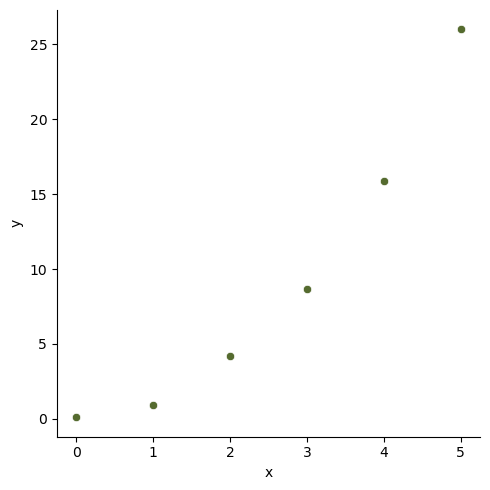

In [53]:
# plot y vs. x
sns.relplot(data = df, x = 'x', y = 'y', color = 'darkolivegreen')

---

These data look non-linear, like they are following a power law. If that's true, we should get a straight line if we plot the log of the values against one another. In order to get these values, we will use the `transform()` method to convert the values into their logs.

In [37]:
df_trans = df.copy()
df_trans['y'] = df['y'].transform(np.log10)
df_trans['x'] = df['x'].transform(np.log10)

/Users/wala/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


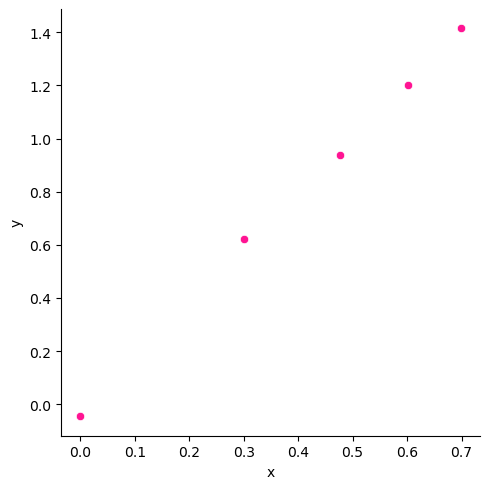

In [42]:
# plot new y vs. new x
sns.relplot(data = df_trans, x = 'x', y = 'y', color = 'deeppink')


Sure enough. The slope of the line should tell us the exponent of the power law, and it looks to be about 2. If that's the case, then transforming the original y-values with a square-root function should also produce a straight line.

In the cells below, use `transform()` to get the square root of the original y values, and plot them against the x values.

In [43]:
# get sqrts
dftransform = df.copy()
dftransform ['y'] = df['y'].transform(np.sqrt)

/Users/wala/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


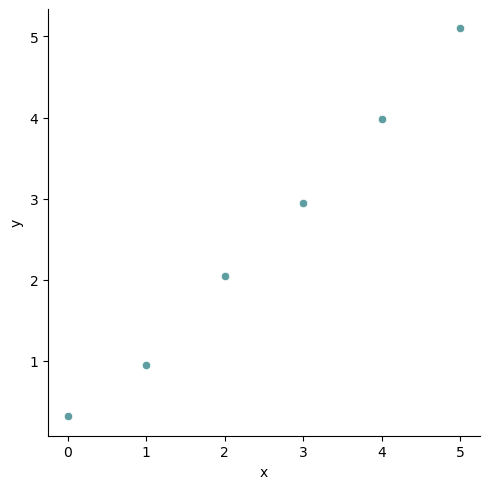

In [44]:
#plot
sns.relplot(data = df_trans, x = 'x', y = 'y', color = 'cadetblue')


---

We could also transform our cancer data. In the cell below, create a new data frame in which the numeric values are the natural log of the original values.

In [46]:
# compute log vals
logs = bcd2.copy()
logs[['thick', 'chrom']] = bcd2[['thick', 'chrom']].transform(np.log)

In [47]:
logs

,id,thick,chrom,class
0,1000025,1.609438,1.098612,benign
1,1002945,1.609438,1.098612,benign
2,1015425,1.098612,1.098612,benign
3,1016277,1.791759,1.098612,benign
4,1017023,1.386294,1.098612,benign
...,...,...,...,...
694,776715,1.098612,0.000000,benign
695,841769,0.693147,0.000000,benign
696,888820,1.609438,2.079442,malignant
697,897471,1.386294,2.302585,malignant


---

### Applying a custom function to data

A great thing about `transform()` (and some other data frame methods) is you can use your own fuctions, not just built in ones.

For `transform()`, the only requirement is that your function

- be able to take a data frame as input
- produce output the same size as the input, or
- produce a single value

Here's a function to "center" data by subtracting the mean from each value. 

In [48]:
def center_data(grp):
    grp_mean = grp.mean(numeric_only = True)
    
    grp = (grp - grp_mean)
    
    return grp

---

In the cell below, use our new function to create a new version of our cancer data frame with the mean removed from each group of data. The `.transform()` method works column-by-column, so you don't need to worry about grouping the data.

In [50]:
transform2 = bcd2.transform(center_data) 

---

Confirm this worked by computing the mean for each column of your transformed data.

In [56]:
transform2.mean(numeric_only = True)

chrom    0.000000e+00
thick    4.071878e-17
dtype: float64

---

In the cells below, write a function to convert the cancer data to z-scores, and use your new function to convert the numeric columns of our cancer data frame.

In [57]:
# my z-score function!
def zed(grp):
    grp_mean = grp.mean(numeric_only = True)
    grp_std = grp.std()
    
    grp = (grp - grp_mean)/grp_std
    
    return grp

In [58]:
# run transform() with my function
transform2 = bcd2[['thick', 'chrom']].transform(zed)

In [59]:
# look at the transformed data
transform2

,thick,chrom
0,0.206942,-0.183305
1,0.206942,-0.183305
2,-0.502864,-0.183305
3,0.561845,-0.183305
4,-0.147961,-0.183305
...,...,...
694,-0.502864,-1.002577
695,-0.857766,-1.002577
696,0.206942,1.864876
697,-0.147961,2.684148


In [60]:
# see what the means are
transform2.mean(numeric_only = True)

thick    3.053909e-17
chrom    6.134182e-17
dtype: float64

In [61]:
# see what the ... are
transform2.std()

thick    1.0
chrom    1.0
dtype: float64

---

#### lambda functions

Lambda functions, also know as anonymous functions, are short, one-off functions that are often used in situation in which ***all*** you need the function for is get passed to a method such as `transform()`

While the structure of a normal function is:

In [63]:
def func_name(input_arg) :
    caluculations
    ret_val = more calculations
    
    return ret_val

SyntaxError: invalid syntax (989757355.py, line 3)

The structure of a lambda function is:

In [64]:
lambda input_arg : calculation of ret_val

SyntaxError: invalid syntax (973877503.py, line 1)

Here's how we would compute z-scores using a lambda function:

In [66]:
trans_data = bcd2[['thick', 'chrom']].transform(
    lambda col_vals: (col_vals - col_vals.mean()) / col_vals.std()
)

Note that the entire lambda function is the one and only input to `transform()`.

---

In the cell below, confirm that the lambda function method worked.

In [67]:
trans_data

,thick,chrom
0,0.206942,-0.183305
1,0.206942,-0.183305
2,-0.502864,-0.183305
3,0.561845,-0.183305
4,-0.147961,-0.183305
...,...,...
694,-0.502864,-1.002577
695,-0.857766,-1.002577
696,0.206942,1.864876
697,-0.147961,2.684148


In [68]:
trans_thick = bcd2['thick'].transform(
    lambda col_vals: (col_vals - col_vals.mean()) / col_vals.std()
)

In [69]:
trans_thick

0      0.206942
1      0.206942
2     -0.502864
3      0.561845
4     -0.147961
         ...   
694   -0.502864
695   -0.857766
696    0.206942
697   -0.147961
698   -0.147961
Name: thick, Length: 699, dtype: float64

---

For very simple transformations, using a lambda function makes a lot of sense. For more complicated transformations, we'd probably want to just create a regular function, or the code could become unreadable. 

How complicated is too complicated? That's up to you, but anything more complicated than applying an offset and a scale factor (like computing a z-score), probably deserves its own function.

---

In the cell below, transform the numeric cancer data so the values range from 0 to 1 using a lambda function. You can assume that the maximum value is 10 and the minimum value is 1.

In [70]:
transformed_data = bcd2.apply(
    lambda x: (x - 1) / (10 - 1) if x.name in bcd2.select_dtypes(include='number').columns else x
)

In [71]:
transformed_data

,id,thick,chrom,class
0,1000025,0.444444,0.222222,benign
1,1002945,0.444444,0.222222,benign
2,1015425,0.222222,0.222222,benign
3,1016277,0.555556,0.222222,benign
4,1017023,0.333333,0.222222,benign
...,...,...,...,...
694,776715,0.222222,0.000000,benign
695,841769,0.111111,0.000000,benign
696,888820,0.444444,0.777778,malignant
697,897471,0.333333,1.000000,malignant


---

In the cell below, us a regular function to rescale the values from 0 to 1. In this case, however, do not assume you know the minimum and maximum values ahead of time.

In [74]:
def rescale2(column):
    if pd.api.types.is_numeric_dtype(column): # using this for numeric aspect 
        min_val = column.min() # generic min and max values 
        max_val = column.max()
        rescaled_column = (column - min_val) / (max_val - min_val) # similar to above 
        return rescaled_column
    else:
        return column

transformed_data = bcd2.apply(rescale2)


---